# Advanced geospatial plotting

In [1]:
# libraries import
import pandas as pd
import os
from keplergl import KeplerGl
from pyproj import CRS
import numpy as np
from matplotlib import pyplot as plt

C:\Users\ZenBook\anaconda3\envs\venv_citybike\Lib\site-packages\keplergl\keplergl.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
# Select in the file only the essential columns for further work

essent_cols = ['start_station_name', 'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng']

df = pd.read_pickle(r"C:\Users\ZenBook\NY_data_merged_seaborn.pkl")[essent_cols]

In [3]:
# check dataframe
df.head()

,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng
0,West End Ave & W 107 St,Mt Morris Park W & W 120 St,40.802116,-73.968178,40.804039,-73.945923
1,4 Ave & 3 St,Boerum Pl\t& Pacific St,40.673744,-73.985649,40.688488,-73.991158
2,1 Ave & E 62 St,5 Ave & E 29 St,40.761227,-73.960938,40.745167,-73.986832
3,2 Ave & E 96 St,5 Ave & E 29 St,40.783962,-73.947166,40.745167,-73.986832
4,6 Ave & W 34 St,5 Ave & E 29 St,40.749641,-73.988052,40.745167,-73.986832


### Checking data quality

In [4]:
df.isnull().sum()

start_station_name        0
end_station_name          0
start_lat                 0
start_lng                 0
end_lat               22369
end_lng               22369
dtype: int64

In [5]:
# Finding common stations present in both start and end columns

common_stations = set(df['start_station_name'].unique()) & set(df['end_station_name'].unique())
len(common_stations)

1742

In [6]:
# Building a station reference table using start‑station coordinates

stations = (df[["start_station_name", "start_lat", "start_lng"]]
    .dropna(subset=["start_lat", "start_lng"])  # remove empty
    .drop_duplicates()
    .rename(columns={
        "start_station_name": "station_name",
        "start_lat": "lat",
        "start_lng": "lng"}))

In [7]:
# Generation a copy of only rows where the end stations have no coordinates
missing_ends = (
    df[df["end_lat"].isna()]
    [["end_station_name"]]
    .drop_duplicates())

In [8]:
# Merging missing end stations with coordinates from the stations table

missing_ends = missing_ends.merge(
    stations,
    how="left",
    left_on="end_station_name",
    right_on="station_name")

In [9]:
# Create dictionaries for quick coordinate lookup by station name
lat_map = dict(zip(missing_ends["end_station_name"], missing_ends["lat"]))
lng_map = dict(zip(missing_ends["end_station_name"], missing_ends["lng"]))

# Fill in missing coordinates directly where they are absent
df.loc[df["end_lat"].isna(), "end_lat"] = df.loc[df["end_lat"].isna(), "end_station_name"].map(lat_map)
df.loc[df["end_lng"].isna(), "end_lng"] = df.loc[df["end_lng"].isna(), "end_station_name"].map(lng_map)

In [10]:
df.isnull().sum()

start_station_name    0
end_station_name      0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
dtype: int64

## Grouping Bike Trips

In [11]:
# creating a new column with the value of 1

df['trips'] = 1

In [12]:
# creating a new aggregated dataframe that contains 3 columns: starting station, ending station, trips

df_group = df.groupby(['start_station_name', 'end_station_name'])['trips'].count().reset_index()

In [13]:
# count of trips between start and end stations
df_group['trips'].sum()

np.int64(12000000)

In [14]:
df_group.shape

(736225, 3)

In [15]:
print(df_group['trips'].sum())
print(df.shape)

12000000
(12000000, 7)


In [16]:
df_group.head()

,start_station_name,end_station_name,trips
0,1 Ave & E 110 St,1 Ave & E 110 St,573
1,1 Ave & E 110 St,1 Ave & E 18 St,1
2,1 Ave & E 110 St,1 Ave & E 44 St,5
3,1 Ave & E 110 St,1 Ave & E 62 St,14
4,1 Ave & E 110 St,1 Ave & E 68 St,18


In [17]:
df_group['trips'].describe()

count    736225.000000
mean         16.299365
std          49.508062
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max        4637.000000
Name: trips, dtype: float64

In [18]:
df_group['trips'].sort_index().value_counts()

trips
1       227839
2       100460
3        59241
4        40571
5        30021
         ...  
678          1
755          1
1333         1
1343         1
2134         1
Name: count, Length: 1023, dtype: int64

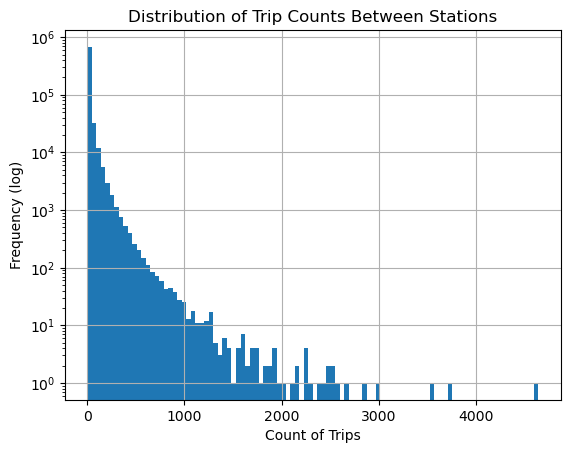

In [19]:
# Distribution histogram of trip counts between stations 

df_group['trips'].hist(bins=100)
plt.yscale('log')  # log scale to handle skewness
plt.xlabel("Count of Trips")
plt.ylabel("Frequency (log)")
plt.title("Distribution of Trip Counts Between Stations")
plt.show()

The histogram shows a highly skewed distribution of trip counts between station pairs. Most station pairs have very few trips, which is why the left side of the plot is extremely tall. As the number of trips increases, the frequency drops off sharply, forming a long tail. Using a logarithmic y‑axis makes this pattern visible: it highlights that only a small number of station pairs experience high traffic, while the majority are used only occasionally.
This pattern is typical for bike‑sharing systems, where a handful of popular routes dominate overall usage.

<Axes: >

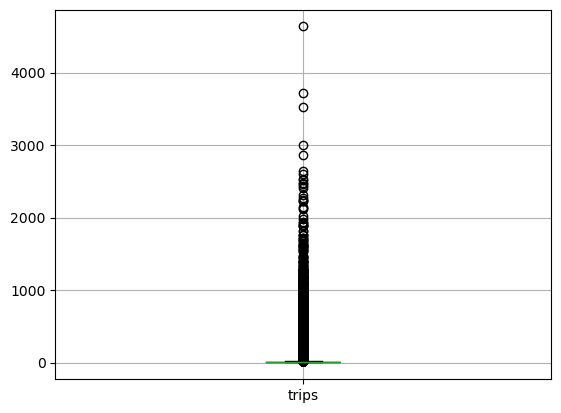

In [20]:
df_group.boxplot(column = 'trips')

In [21]:
df_group.to_csv('df_groupby_trips.csv')

### Adding coordinates

In [22]:
# Extracting unique start station coordinates
start_coords = df[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates('start_station_name')

In [23]:
# Extracting unique end station coordinates
end_coords = df[['end_station_name', 'end_lat', 'end_lng']].drop_duplicates('end_station_name')

In [24]:
df_trips = df_group.merge(start_coords, on='start_station_name', how='left')

In [25]:
df_trips = df_trips.merge(end_coords, on='end_station_name', how='left')

In [26]:
df_trips.head()

,start_station_name,end_station_name,trips,start_lat,start_lng,end_lat,end_lng
0,1 Ave & E 110 St,1 Ave & E 110 St,573,40.792328,-73.938301,40.792328,-73.938301
1,1 Ave & E 110 St,1 Ave & E 18 St,1,40.792328,-73.938301,40.733810,-73.980545
2,1 Ave & E 110 St,1 Ave & E 44 St,5,40.792328,-73.938301,40.750019,-73.969055
3,1 Ave & E 110 St,1 Ave & E 62 St,14,40.792328,-73.938301,40.761227,-73.960938
4,1 Ave & E 110 St,1 Ave & E 68 St,18,40.792328,-73.938301,40.765007,-73.958183


In [27]:
df_trips.shape

(736225, 7)

In [28]:
df_trips.to_pickle('df_trips_coordinates.pkl')

## Creating a Map in Kepler.gl

In [29]:
df_trips['trips'].describe()

count    736225.000000
mean         16.299365
std          49.508062
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max        4637.000000
Name: trips, dtype: float64

This summary describes all unique start–end station routes in the dataset.
There are 736225 unique routes recorded. This shows that the CityBike network generates a very large number of distinct station‑to‑station combinations, most of which are used only occasionally.
On average, each route is taken about 16 times. This low mean already hints at a highly skewed distribution where most routes are rare.
The standard deviation is much larger than the mean, indicating strong variability: some routes are used only once, while others are used hundreds or thousands of times.
The least popular routes occur only once (min = 1). This is extremely common in large mobility networks, where many station pairs are used only sporadically.
A full 25% of all routes (25% = 1) are used exactly once. This confirms that the long tail of rare routes is very large.
Half of all routes have 3 trips or fewer (50% (median) = 3). The median being so low shows that the majority of routes are lightly used.
Three‑quarters of all routes have 11 trips or fewer (75% = 11). Only the top 25% of routes exceed this threshold.
The most popular route has 4637 trips (max = 4637), showing a dramatic contrast between the busiest and the least used routes. This is typical of urban mobility systems where a small number of routes dominate overall traffic.
This pattern is quite common in real‑world bike‑sharing systems, where only a few city station pairs become major mobility corridors.

In [30]:
import gc # this is garbage collector - speeds up performance
gc.collect()

18690

Purpose of the visualization

The aim of this Kepler.gl map is to visualize the CityBike trips across New York City and understand where demand is concentrated. 

Used:
**Arc layer** — to draw connections between start and end stations,
**Heat/color scale** — to mark the start and end point of trip,

Done in Python:
Creating a new aggregated dataframe that contains 3 columns: starting station, ending station, trips.
Merged coordinates into the aggregated dataframe, so Kepler can draw arcs.

Loaded into Kepler.gl and applied:
Arc Layer (Start → End station)
Color encoding

Result: Obtained the map that demonstrates the most common trips in New York City, explaining the most and least busy zones.

## Instance of a Kepler.gl map

In [35]:
# Create KeplerGl instance

map_K = KeplerGl(height = 900, data={"data_1": df_trips})
map_K

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_1':            start_station_name         end_station_name  trips  start_lat  \
0        …

The Kepler map visualizes CityBike trips in New Your in 2022 using arc connections between start (green dots) and end (blue dots) stations.
Arc color intensity reflects route popularity: brighter arcs (yellow) = more trips, darker arcs (violet) = fewer trips.
I customized the map by assigning a contrasting color palette to the points and arcs, making it easier to distinguish station locations from the flow of trips between them. I also enabled the arc layer and adjusted its color scale to highlight route intensity, improving the visual clarity of the most frequently traveled connections.

After using Filter:
-The densest clusters of arcs appear in Midtown and Lower Manhattan, driven by commuter flows and tourism.
-Strong recreational patterns are visible around Central Park and the Hudson River Greenway.
-Route density drops sharply outside Manhattan due to lower station density and less bike infrastructure.
-Outer boroughs (Queens, Bronx, deeper Brooklyn) show far fewer arcs.
-Jersey City and Roosevelt Island appear as small, isolated pockets of activity.

Overall, the map clearly indicates that CityBike demand is concentrated in the core of Manhattan, where trips are short, dense, and repetitive. These pattern suggests that bike rebalancing and fleet distribution should prioritize central Manhattan and the key corridors highlighted on the map.

### Saving settings and Exporting the Map

In [36]:
config = map_K.config

In [37]:
config

{'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': ['data_1'],
     'id': 'e8jfsllb',
     'name': ['trips'],
     'type': 'range',
     'value': [432, 4637],
     'enlarged': False,
     'plotType': 'histogram',
     'animationWindow': 'free',
     'yAxis': None,
     'speed': 1}],
   'layers': [{'id': '3hasbwa',
     'type': 'point',
     'config': {'dataId': 'data_1',
      'label': 'start',
      'color': [106, 187, 107],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'start_lat', 'lng': 'start_lng', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       '

In [38]:
import json
with open("config.json", "w") as outfile:
    json.dump(config, outfile)

In [39]:
map_K.save_to_html(file_name = 'NY_2022_CityBike_Map.html', read_only = False, config = config)

Map saved to NY_2022_CityBike_Map.html!
